<h1 style="text-align:center; font-size:40px; color:black;"> Property Value Prediction </h1>

#  📖 Introduction

---


This dataset comes from Zillow and contains information on residential properties, including physical features, location details, and tax-assessed values (`taxvaluedollarcnt`). Features include things like square footage, number of rooms, lot size, year built, and geographic coordinates.  


**Objective:** Predict property tax values using available features to provide more accurate estimates. This can help Zillow improve user trust, highlight undervalued properties, and guide marketing strategies.

**Success Metrics:** Model performance is measured by prediction accuracy using metrics like RMSE or MAE. High accuracy indicates reliable predictions that support smarter real estate decisions.
ons.


In [2]:
# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

In [3]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## About the Dataset

In [3]:
# Check shape and columns
print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")

print("\nFirst 5 rows:")
display(df.head())

# Check nulls
print("\nMissing Values Summary:\n")
missing = df.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])

# Descriptive stats
print("\nDescriptive Statistics:")
display(df.describe())

Dataset Shape: 77613 rows, 55 columns

First 5 rows:


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0



Missing Values Summary:

buildingclasstypeid             77598
finishedsquarefeet13            77571
storytypeid                     77563
basementsqft                    77563
yardbuildingsqft26              77543
fireplaceflag                   77441
architecturalstyletypeid        77406
typeconstructiontypeid          77390
finishedsquarefeet6             77227
pooltypeid10                    77148
decktypeid                      76999
poolsizesum                     76744
pooltypeid2                     76539
hashottuborspa                  76074
yardbuildingsqft17              75220
taxdelinquencyflag              74713
taxdelinquencyyear              74713
finishedsquarefeet15            74586
finishedsquarefeet50            71576
finishedfloor1squarefeet        71576
fireplacecnt                    69324
threequarterbathnbr             67507
pooltypeid7                     62534
poolcnt                         61439
numberofstories                 60014
airconditioningtypeid   

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,assessmentyear,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
count,7.761300e+04,25007.000000,207.000000,50.000000,77579.000000,77579.000000,15.000000,49809.000000,76963.000000,614.0,...,223.000000,50703.000000,2393.000000,70.000000,77309.000000,17599.000000,77579.0,2900.000000,7.733200e+04,7.757800e+04
mean,1.300781e+07,1.812013,7.386473,679.720000,2.298496,3.053223,3.933333,6.533779,2.316392,66.0,...,6.040359,1.110309,305.460928,216.385714,1968.611507,1.434286,2016.0,14.088276,6.049667e+13,4.901506e+05
std,3.518717e+06,2.965768,2.728030,689.703546,0.996732,1.140480,0.258199,1.722062,0.979689,0.0,...,0.556035,1.169967,238.735241,190.177514,23.793171,0.544515,0.0,2.181281,1.533339e+12,6.537979e+05
min,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,...,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,2016.0,3.000000,6.037101e+13,1.000000e+03
25%,1.153821e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,...,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,2016.0,14.000000,6.037311e+13,2.068985e+05
50%,1.253004e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,...,6.000000,1.000000,250.000000,164.500000,1970.000000,1.000000,2016.0,15.000000,6.037603e+13,3.588785e+05
75%,1.421101e+07,1.000000,7.000000,796.500000,3.000000,4.000000,4.000000,8.000000,3.000000,66.0,...,6.000000,1.000000,364.000000,310.500000,1987.000000,2.000000,2016.0,15.000000,6.059042e+13,5.690000e+05
max,1.676893e+08,13.000000,21.000000,3560.000000,18.000000,16.000000,4.000000,12.000000,18.000000,66.0,...,13.000000,237.000000,3191.000000,868.000000,2016.000000,6.000000,2016.0,99.000000,4.830301e+14,4.906124e+07


In [4]:
# Overview: Look at dtypes, unique values, and missing %
feature_info = pd.DataFrame({
    'DataType': df.dtypes,
    '% Missing': (df.isnull().sum() / len(df)) * 100,
    '# UniqueValues': df.nunique()
}).sort_values(by='% Missing', ascending=False)

print("Data Overview")
feature_info

Data Overview


,DataType,% Missing,# UniqueValues
buildingclasstypeid,float64,99.980673,2
finishedsquarefeet13,float64,99.945885,13
storytypeid,float64,99.935578,1
basementsqft,float64,99.935578,43
yardbuildingsqft26,float64,99.909809,59
fireplaceflag,object,99.778388,1
architecturalstyletypeid,float64,99.733292,5
typeconstructiontypeid,float64,99.712677,4
finishedsquarefeet6,float64,99.502661,350
pooltypeid10,float64,99.400874,1


<div style="border-radius: 10px; border: purple solid;  padding: 10px; background-color: #; font-size: 100%;">
    
**Key findings:**
- The dataset has about **77,613 rows** and **55 columns**.
- Many features have significant missing values, so we’ll need to handle these during cleaning.
- The target variable `taxvaluedollarcnt` is **heavily right-skewed**, showing a few high-value outliers.

# 👀 Exploratory Data Analysis (EDA)

---

First, generate histograms for all numerical features to get an overview of their distributions.



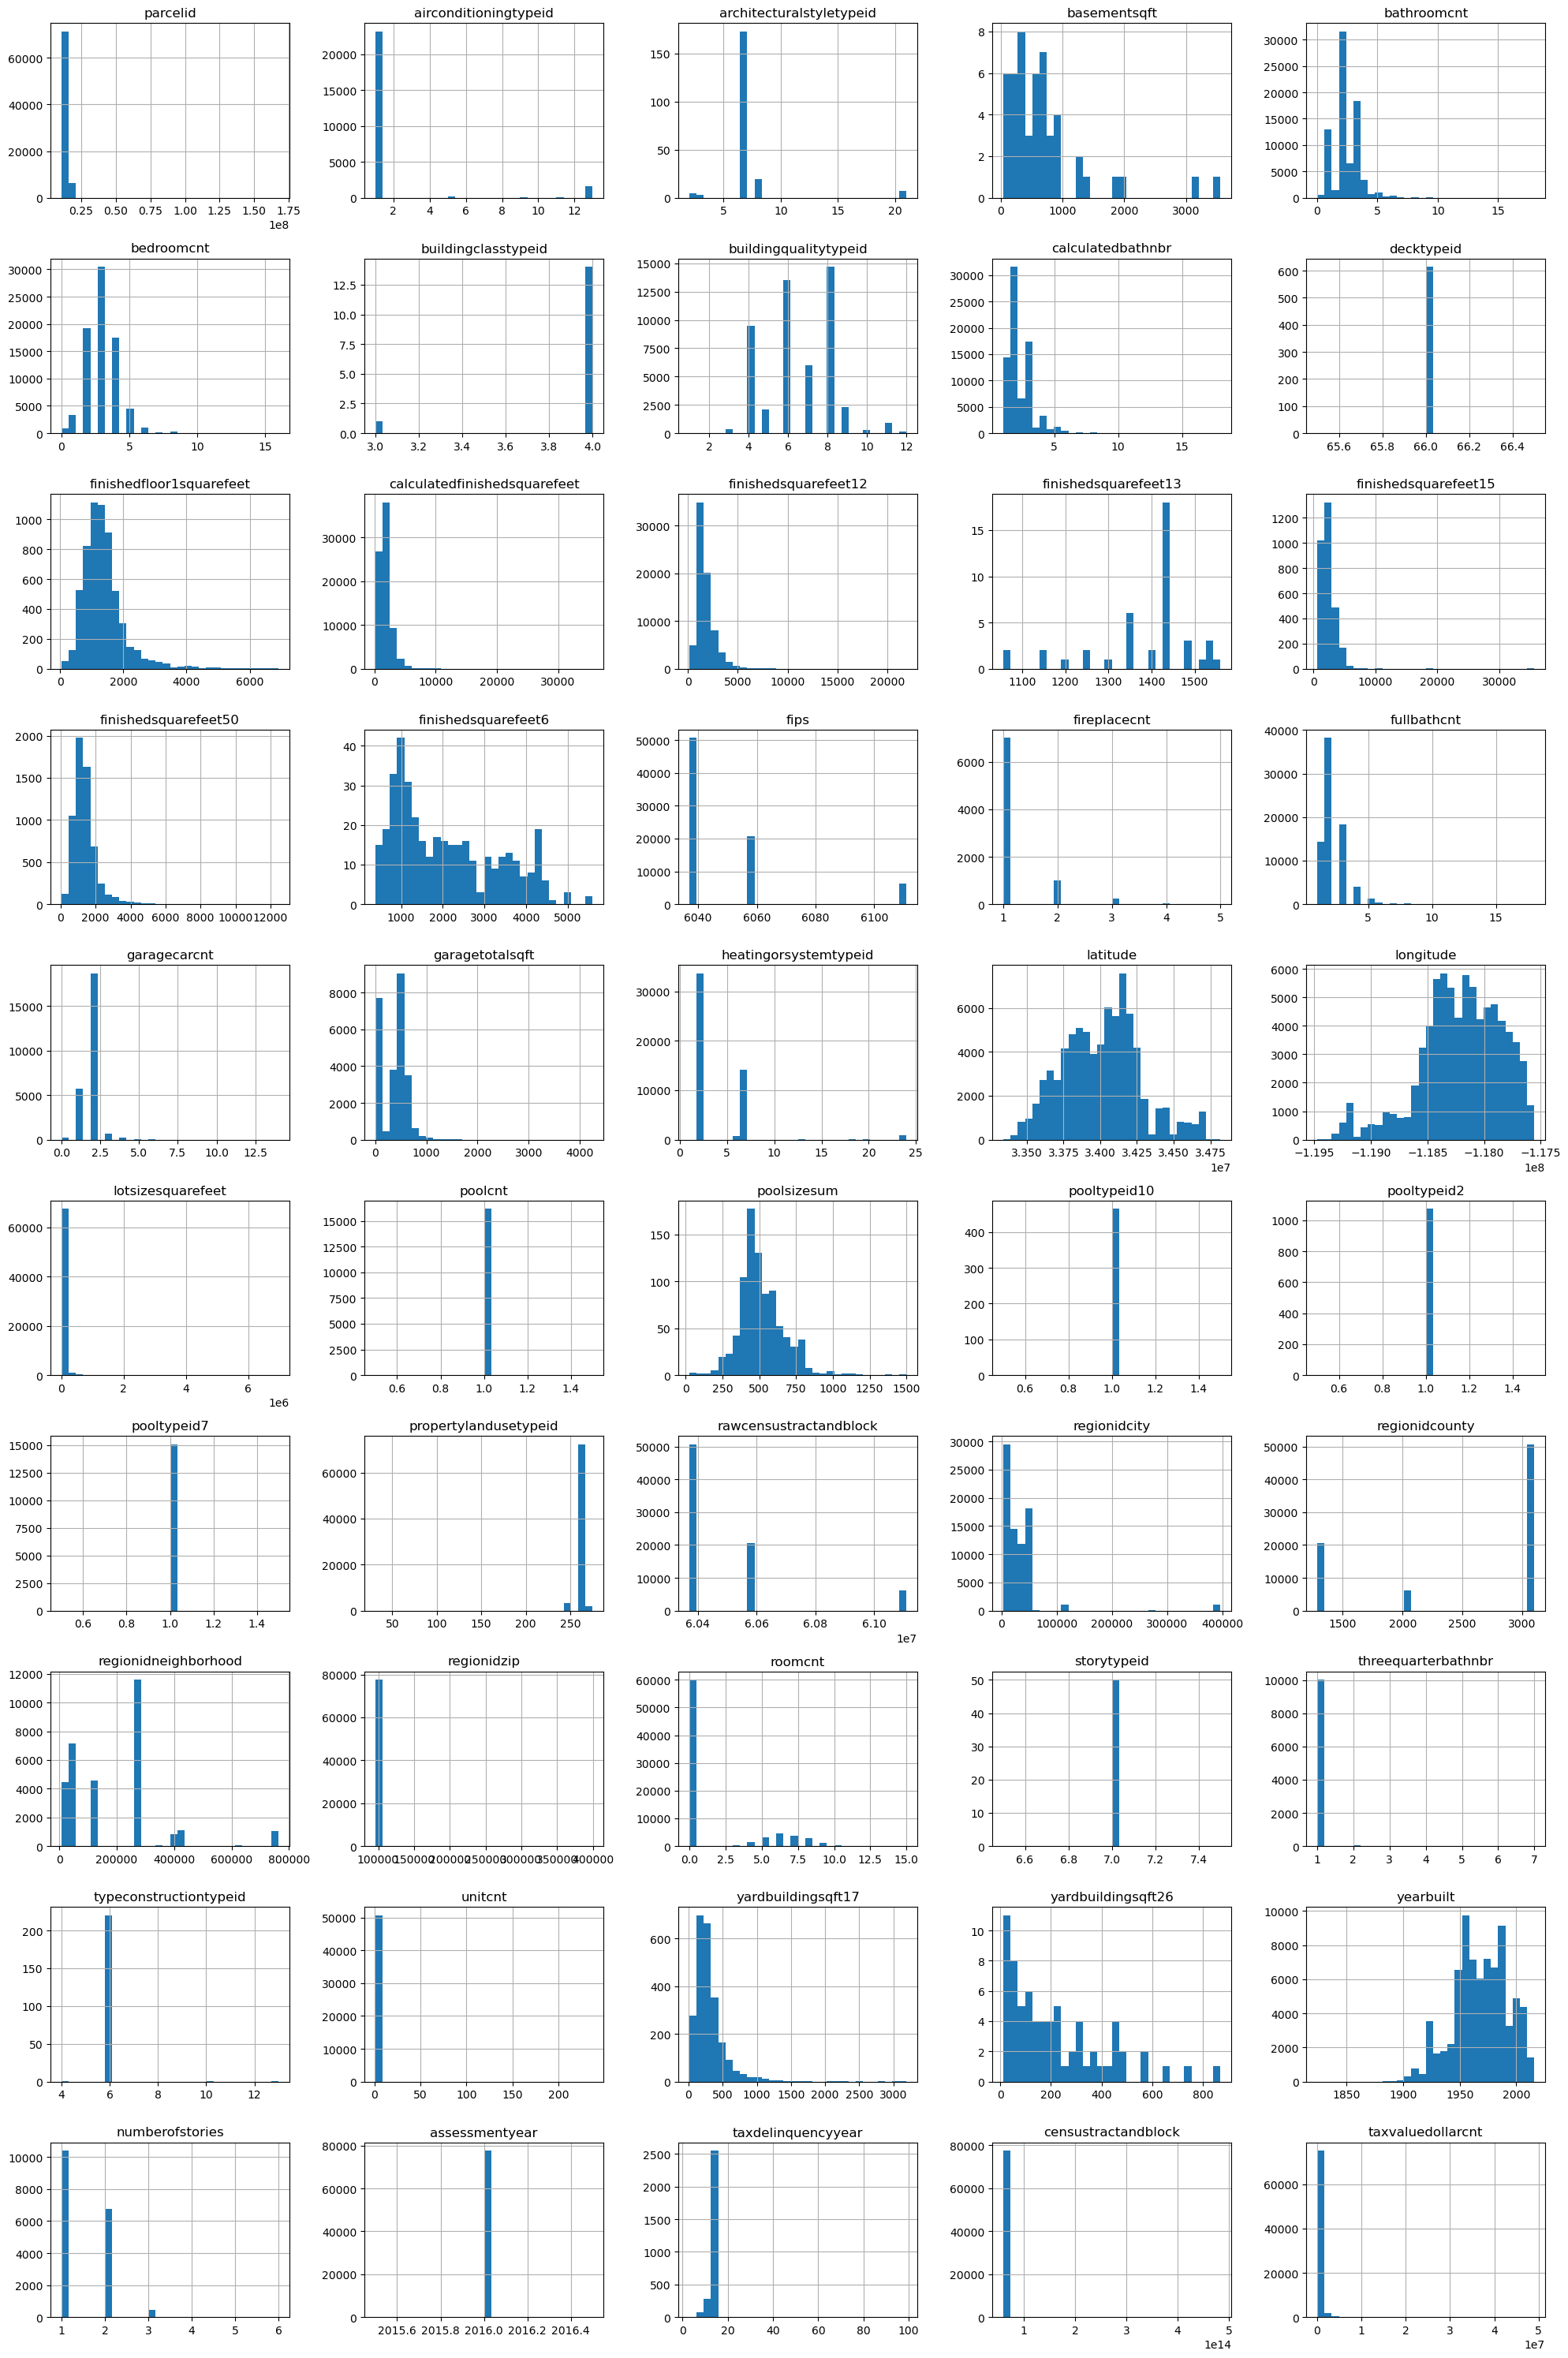

In [5]:
# All-feature histograms
df.hist(figsize=(20, 30), layout=(-1, 5), bins=30)
plt.tight_layout()
plt.show()

### Distribution of the target variable (`taxvaluedollarcnt`)

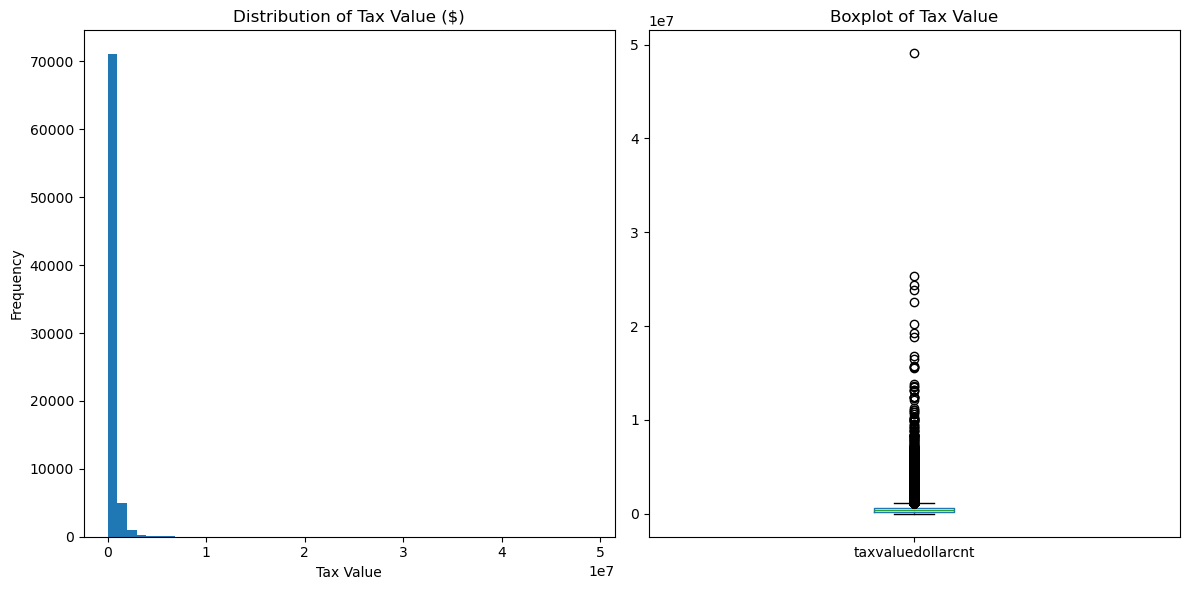

In [6]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
df['taxvaluedollarcnt'].hist(bins=50, grid=False)
plt.title("Distribution of Tax Value ($)")
plt.xlabel("Tax Value")
plt.ylabel("Frequency")

# Boxplot
plt.subplot(1, 2, 2)
df.boxplot(column='taxvaluedollarcnt', grid=False)
plt.title("Boxplot of Tax Value")

plt.tight_layout()
plt.show()


### Looking into Features

#### Feature 1: `bedroomcnt`

* The number of bedrooms likely affects property value.

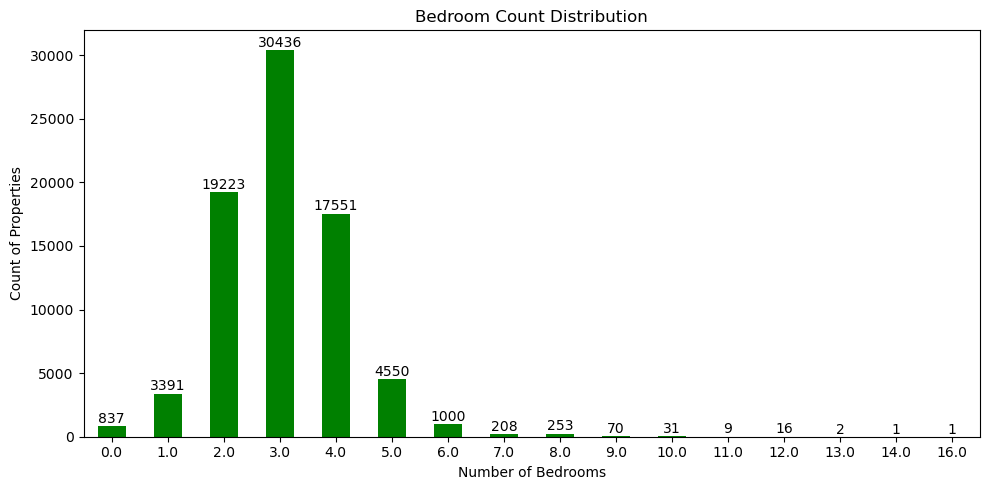

In [7]:
plt.figure(figsize=(10, 5))

bedroom_counts = df['bedroomcnt'].value_counts().sort_index()

bars = bedroom_counts.plot(kind='bar', color='green')

# Add count labels
for i, count in enumerate(bedroom_counts):
    plt.text(i, count + 10, str(int(count)), ha='center', va='bottom')

plt.title('Bedroom Count Distribution')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count of Properties')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

<div style="border-radius: 10px; border: orange solid;  padding: 10px; background-color: #; font-size: 100%;">

- The majority of properties have **2 to 4 bedrooms**, with **3-bedroom homes being the most common** (30,436).
- Homes with **0 or 1 bedroom** are relatively rare, suggesting that most properties are not studio-style or one-bedroom units.
- There’s a **sharp drop** in frequency after 5 bedrooms - homes with **6 or more bedrooms are much less common**, likely representing luxury or multi-family homes.
- Extremely large properties with **10+ bedrooms are very rare**.

#### Feature 2: `bathroomcnt`

* Like bedrooms, bathrooms impact property price. Useful to compare with bedrooms too.

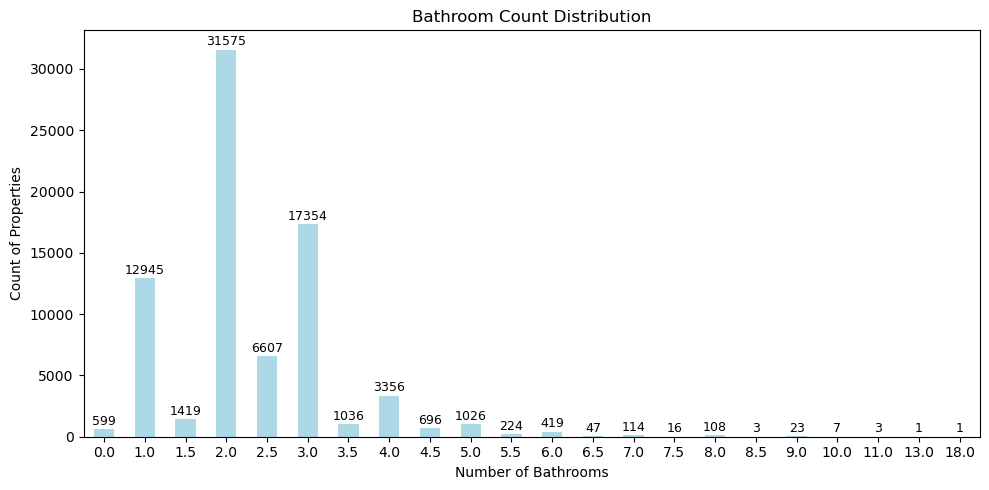

In [8]:
bath_counts = df['bathroomcnt'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 5))
bars = bath_counts.plot(kind='bar', color='lightblue')
plt.title('Bathroom Count Distribution')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count of Properties')
plt.xticks(rotation=0)

for i, count in enumerate(bath_counts):
    plt.text(i, count + 100, str(int(count)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

<div style="border-radius: 10px; border: orange solid;  padding: 10px; background-color: #; font-size: 100%;">

- Most homes have **2 or 3 bathrooms** bathrooms.
- Some homes have half bathrooms (like 1.5 or 2.5), which means they have a toilet and sink but no shower or tub.
- Very high bathroom counts (8+, with up to 18 bathrooms) are extremely rare and may represent luxury or atypical properties.
- There are **599 homes** with **0 bathrooms**, which might be an error or land with no house built yet.

#### Feature 3: `calculatedfinishedsquarefeet`

- This is a measure of total living space, which is highly correlated with home value.

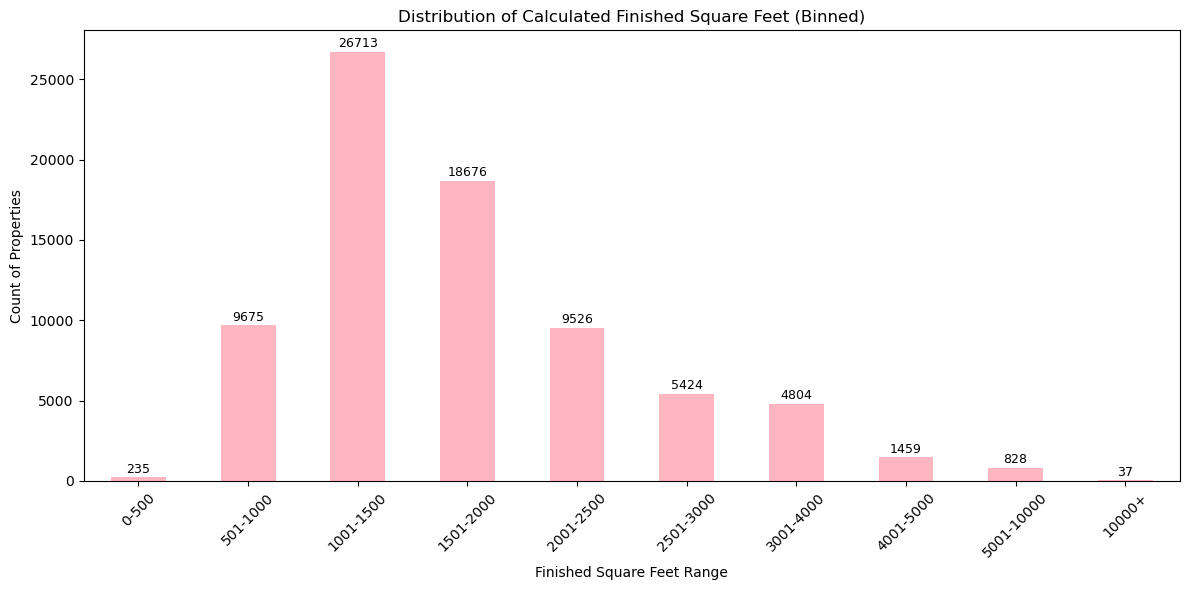

In [9]:
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 10000, df['calculatedfinishedsquarefeet'].max()]
labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001-2500',
          '2501-3000', '3001-4000', '4001-5000', '5001-10000', '10000+']

# Create a temporary binned series 
sqft_binned = pd.cut(df['calculatedfinishedsquarefeet'], bins=bins, labels=labels, right=False)

# Count 
sqft_bin_counts = sqft_binned.value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars = sqft_bin_counts.plot(kind='bar', color='lightpink')
plt.title('Distribution of Calculated Finished Square Feet (Binned)')
plt.xlabel('Finished Square Feet Range')
plt.ylabel('Count of Properties')
plt.xticks(rotation=45)

for i, count in enumerate(sqft_bin_counts):
    plt.text(i, count + 100, str(int(count)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

<div style="border-radius: 10px; border: orange solid;  padding: 10px; background-color: #; font-size: 100%;">

- Most properties have a finished living area between **1001 - 1500 square feet** (26,713 properties), followed by the **1501 - 2000 square feet** range (18,676 properties).
- There are fewer properties with very small finished areas (0-500 sqft) - only 235 properties.
- The number of properties decreases as the square footage increases beyond 2000 sqft.
- Very large homes over **10,000 square feet** are rare, with only 37 properties in this range.

# 🧹 Data Cleaning

---

### Drop Unsuitable Features

In [10]:
def drop_unsuitable_features(df):
    cols_to_drop = [
        'parcelid',              # Unique ID
        'assessmentyear',        # Only one value
        'decktypeid',            # Only one unique value
        'regionidzip',            # Redundant with lat/lon
        'censustractandblock'    # identifier
    ]
    
    df = df.drop(columns=cols_to_drop, errors='ignore')
    return df

# Apply
df = drop_unsuitable_features(df)

# Check remaining columns
print("Number of columns remaining:", df.shape[1])
print("\nColumns after dropping:\n", df.columns.tolist())


Number of columns remaining: 50

Columns after dropping:
 ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag',

<div style="border-radius: 10px; border: orange solid;  padding: 10px; background-color: #; font-size: 100%;">

Removed columns that aren’t helpful for predicting property value. After dropping, there are 50 columns remain.
- **`parcelid`**: This is just a unique identifier for each property. It doesn’t contain any information useful for predicting property value.

- **`assessmentyear`**: Every row has the same value (2016), so there's no variation. It doesn’t help the model learn anything.

- **`decktypeid`**: Has only one unique value in the dataset. Features with no variety don’t help the model.

- **`regionidzip`**: ZIP code is too broad. We have better location data with `latitude` and `longitude`, which are more precise.

- **`censustractandblock`**: This is a combined identifier. It doesn’t contain any information useful for predicting property value.


### Drop **features** with "too many" null values


In [11]:
threshold = 95  # Columns with more than 95% missing values


missing_pct = df.isnull().mean().sort_values(ascending=False) * 100
cols_to_drop = missing_pct[missing_pct > threshold].index.tolist()


print(f"Columns with > {threshold}% missing values ({len(cols_to_drop)}):\n")
print(cols_to_drop)

Columns with > 95% missing values (17):

['buildingclasstypeid', 'finishedsquarefeet13', 'storytypeid', 'basementsqft', 'yardbuildingsqft26', 'fireplaceflag', 'architecturalstyletypeid', 'typeconstructiontypeid', 'finishedsquarefeet6', 'pooltypeid10', 'poolsizesum', 'pooltypeid2', 'hashottuborspa', 'yardbuildingsqft17', 'taxdelinquencyyear', 'taxdelinquencyflag', 'finishedsquarefeet15']


In [12]:
# Drop the high-null columns
df = df.drop(columns=cols_to_drop)

# Final shape
print(f"Remaining columns after dropping features with > 95% missing values: {df.shape[1]}")

Remaining columns after dropping features with > 95% missing values: 33


<div style="border-radius: 10px; border: purple solid; padding: 10px; font-size: 100%;">
    
To clean the dataset, the percentage of missing values for each feature was calculated, and features with more than <strong>95% missing data</strong> were dropped.

**17** features were removed. These columns were mostly empty, difficult to impute meaningfully, and unlikely to improve the regression model.

After removing them, **33** features remained for further cleaning and analysis.
</div>



###  Drop Problematic **samples** 

In [13]:
print("Initial number of rows:", df.shape)

Initial number of rows: (77613, 33)


In [14]:
# Drop rows where target (taxvaluedollarcnt) is null
before = df.shape[0]
df = df[df['taxvaluedollarcnt'].notnull()]
after = df.shape[0]

print(f"Dropped {before - after} rows with missing target. Rows remaining: {after}")

Dropped 35 rows with missing target. Rows remaining: 77578


In [15]:
# Drop outliers in taxvaluedollarcnt using IQR method
Q1 = df['taxvaluedollarcnt'].quantile(0.25)
Q3 = df['taxvaluedollarcnt'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 3 * IQR

before = df.shape[0]
df = df[df['taxvaluedollarcnt'] <= upper_bound]
after = df.shape[0]
print(f"Dropped {before - after} outliers above {upper_bound:,.0f}. Rows remaining: {after}")

Dropped 2350 outliers above 1,655,304. Rows remaining: 75228


In [16]:
row_missing_pct = df.isnull().mean(axis=1)

# drop rows where more than 40% of features are missing.
threshold = 0.40

before = df.shape[0]
df = df[row_missing_pct <= threshold]
after = df.shape[0]

print(f"Dropped {before - after} rows with > {int(threshold * 100)}% missing values. Rows Remaining: {after}")

Dropped 3080 rows with > 40% missing values. Rows Remaining: 72148


<div style="border-radius: 10px; border: purple solid; padding: 10px; font-size: 100%;">
    
Further cleaning of the data involved removing samples with clear issues. First, __35 rows__ with missing values in the target variable <code>taxvaluedollarcnt</code> were dropped, as they cannot be used in regression tasks. Next, __2,350 extreme outliers__ in the target were removed using the IQR method (Q3 + 3×IQR) to reduce skew and prevent them from dominating the model. Additionally, __3,080 rows__ missing more than 40% of their feature values were removed, as these rows likely lack sufficient information to be useful or accurately imputed.

After these steps, 72,148 samples remained for modeling.
</div>


### Impute for the remaining missing values


In [17]:
# Check missing columns
missing_cols = df.columns[df.isnull().any()]
print(f"Total columns with missing values: {len(missing_cols)}")
print("\nColumns with missing values:", missing_cols.tolist())

# Print missing value counts sorted descending
missing_analysis = pd.DataFrame({
    'Missing Count': df[missing_cols].isnull().sum(),
    'DataType': df[missing_cols].dtypes
}).sort_values('Missing Count', ascending=False)

# Display the analysis
print()
print(missing_analysis)

Total columns with missing values: 22

Columns with missing values: ['airconditioningtypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet50', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'pooltypeid7', 'propertyzoningdesc', 'regionidcity', 'regionidneighborhood', 'threequarterbathnbr', 'unitcnt', 'yearbuilt', 'numberofstories']

                              Missing Count DataType
finishedfloor1squarefeet              66180  float64
finishedsquarefeet50                  66180  float64
fireplacecnt                          64054  float64
threequarterbathnbr                   62617  float64
pooltypeid7                           58033  float64
poolcnt                               57152  float64
numberofstories                       55453  float64
garagecarcnt                          49197  float64
garageto

<div style="border-radius: 10px; border: orange solid; padding: 10px;font-size: 100%;"> 

Out of 33 columns, we found **22 features** still contain missing values. Most of these are numeric types, with a few categorical ones like `propertyzoningdesc`. Some columns, such as `finishedfloor1squarefeet` and `finishedsquarefeet50`, are missing values in over 60,000 rows. Other features, like `yearbuilt` and `censustractandblock`, have much fewer missing values. Our next step is to fill (impute) these values using methods based on each column’s type and likely meaning. 

- ####  1. Fill with 0

These features describe things that might not exist on some properties (like garages, pools, etc.).

In [18]:
cols_zero_fill = [
    'garagecarcnt',            # number of cars garage can hold
    'garagetotalsqft',         # garage size
    'fireplacecnt',            # number of fireplaces
    'poolcnt',                 # number of pools
    'pooltypeid7',             # type of pool
    'threequarterbathnbr'      # number of 3/4 bathrooms
]

for col in cols_zero_fill:
    filled = df[col].isnull().sum()
    df[col] = df[col].fillna(0)

# check 
print("Missing after Step 1:")
print(df[cols_zero_fill].isnull().sum())

Missing after Step 1:
garagecarcnt           0
garagetotalsqft        0
fireplacecnt           0
poolcnt                0
pooltypeid7            0
threequarterbathnbr    0
dtype: int64


- #### 2. Fill categorical with Mode or 'Unknown'
Using mode keeps consistency; using 'Unknown' avoids dropping or falsely assigning a category.

In [19]:
mode_fill = ['airconditioningtypeid', 'heatingorsystemtypeid', 'buildingqualitytypeid']
for col in mode_fill:
    filled = df[col].isnull().sum()
    df[col] = df[col].fillna(df[col].mode().iloc[0])

# 'Unknown' for text category
filled = df['propertyzoningdesc'].isnull().sum()
df['propertyzoningdesc'] = df['propertyzoningdesc'].fillna('Unknown')

# Check missing after this step
print("Missing after Step 2:")
print(df[mode_fill + ['propertyzoningdesc']].isnull().sum())

Missing after Step 2:
airconditioningtypeid    0
heatingorsystemtypeid    0
buildingqualitytypeid    0
propertyzoningdesc       0
dtype: int64


- #### 3. Fill numeric columns with Median

In [20]:
median_fill = [
    'lotsizesquarefeet', 'regionidneighborhood', 'regionidcity',
    'unitcnt', 'numberofstories', 'yearbuilt',
    'fullbathcnt', 'calculatedbathnbr', 'finishedfloor1squarefeet',
    'finishedsquarefeet50', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12']

for col in median_fill:
    filled = df[col].isnull().sum()
    df[col] = df[col].fillna(df[col].median())

# Final check
print("Missing after Step 3:")
print(df[median_fill].isnull().sum())

Missing after Step 3:
lotsizesquarefeet               0
regionidneighborhood            0
regionidcity                    0
unitcnt                         0
numberofstories                 0
yearbuilt                       0
fullbathcnt                     0
calculatedbathnbr               0
finishedfloor1squarefeet        0
finishedsquarefeet50            0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
dtype: int64


In [21]:
total_missing = df.isnull().sum().sum()
print(f"Total remaining missing values in dataset: {total_missing}")

Total remaining missing values in dataset: 0


<div style="border-radius: 10px; border: purple solid; padding: 10px; font-size: 100%;">

Missing values were imputed based on the context and nature of each column. For numeric features that represent physical property attributes - such as garage size, pool count, or fireplaces - missing values were replaced with 0 since that missing implies absence. Categorical features with coded types, such as air conditioning or heating systems, were filled using the mode - the most common category in the dataset. For text categorical fields like zoning descriptions, missing values were replaced with "Unknown". Remaining numeric features, such as lot size and year built, were imputed using the median to avoid the impact of very large or small values. This approach helped keep the data accurate and complete without making big changes.

### Encode the Categorical Features? 


In [22]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['propertycountylandusecode', 'propertyzoningdesc']


In [23]:
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

propertycountylandusecode: 58 unique values
propertyzoningdesc: 1869 unique values


---
No categorical features were encoded at this point, as encoding is not required for the current analysis goals. The columns `propertycountylandusecode` and `propertyzoningdesc` remain unchanged.

### 💾 Save Cleaned File

In [24]:
df.to_csv("zillow_cleaned.csv", index=False)

# 🔍 Investigate Feature Relationships---


- ####  Compute the correlation matrix for all numeric features


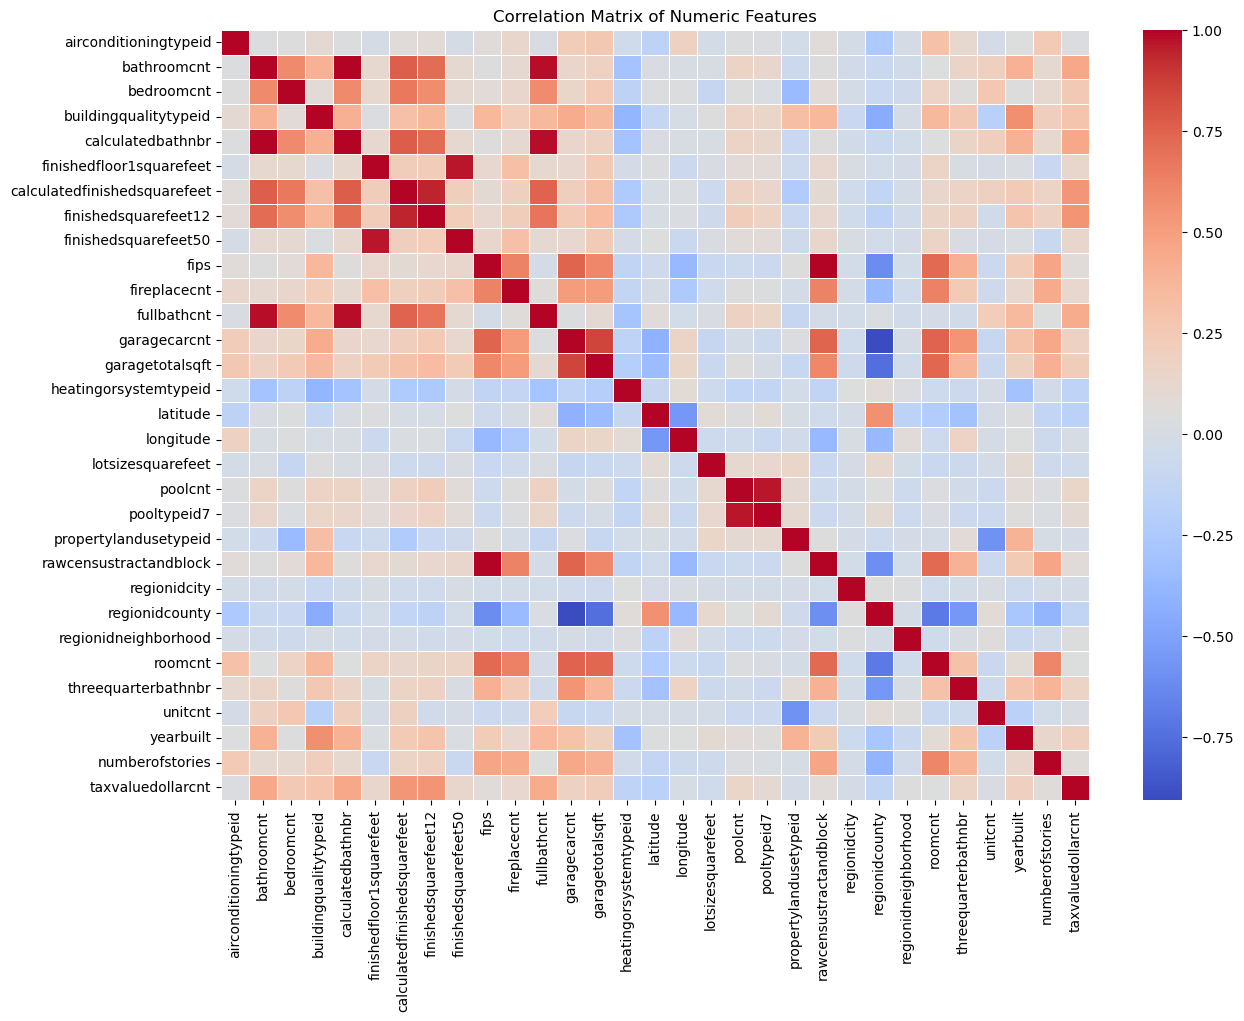

In [24]:
corr_matrix = df.corr(numeric_only=True)

# Display heatmap of correlations
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [25]:
# Get correlation of all features with the target
target_corr = corr_matrix['taxvaluedollarcnt'].drop('taxvaluedollarcnt')  

# Sort correlations
sorted_corr = target_corr.sort_values(ascending=False)

print("Correlation of Each Feature with 'taxvaluedollarcnt':\n")
print(sorted_corr.round(2))

Correlation of Each Feature with 'taxvaluedollarcnt':

finishedsquarefeet12            0.55
calculatedfinishedsquarefeet    0.54
calculatedbathnbr               0.45
bathroomcnt                     0.45
fullbathcnt                     0.43
buildingqualitytypeid           0.29
bedroomcnt                      0.26
garagetotalsqft                 0.22
yearbuilt                       0.20
garagecarcnt                    0.18
threequarterbathnbr             0.16
poolcnt                         0.15
finishedfloor1squarefeet        0.14
finishedsquarefeet50            0.13
fireplacecnt                    0.12
pooltypeid7                     0.10
fips                            0.08
rawcensustractandblock          0.07
numberofstories                 0.07
regionidneighborhood            0.05
roomcnt                         0.05
airconditioningtypeid           0.03
unitcnt                         0.01
longitude                       0.00
regionidcity                   -0.01
propertylandusetypei

<div style="border-radius: 10px; border: orange solid; padding: 10px; font-size: 100%;">


- __Strong positive correlation:__ `finishedsquarefeet12`(0.55) and `calculatedfinishedsquarefeet` (0.54) and `bathroom` counts (0.45) show the strongest links to property tax value.

- __Moderate correlation:__ `buildingqualitytypeid`, `bedroomcnt`, and `garage` features have moderate positive relationships.

- __Weak or negative correlation:__ Most other features show weak or slightly negative correlations, likely less impactful.

- #### Compute F-statistics for All Features
Using **f_regression** from sklearn’s feature_selection to calculate the F-statistic and p-values.

In [26]:
# Separate features and target
X_numeric = df.select_dtypes(include=[np.number]).drop(columns=['taxvaluedollarcnt'])
y = df['taxvaluedollarcnt']

# Compute F-statistic and p-values
f_stats, p_values = f_regression(X_numeric, y)

# Create DataFrame for F-statistics
f_stat_df = pd.DataFrame({
    'Feature': X_numeric.columns,
    'F_statistic': f_stats,
    'p_value': p_values
}).sort_values(by='F_statistic', ascending=False)

print("Features by F-statistic:")
print(f_stat_df)

Features by F-statistic:
                         Feature   F_statistic        p_value
7           finishedsquarefeet12  30943.405803   0.000000e+00
6   calculatedfinishedsquarefeet  29858.304958   0.000000e+00
4              calculatedbathnbr  18801.420535   0.000000e+00
1                    bathroomcnt  18632.356104   0.000000e+00
11                   fullbathcnt  16219.367203   0.000000e+00
3          buildingqualitytypeid   6478.705343   0.000000e+00
2                     bedroomcnt   5041.941039   0.000000e+00
13               garagetotalsqft   3609.486216   0.000000e+00
28                     yearbuilt   3097.048415   0.000000e+00
12                  garagecarcnt   2366.234428   0.000000e+00
15                      latitude   2146.227696   0.000000e+00
26           threequarterbathnbr   1897.011282   0.000000e+00
14         heatingorsystemtypeid   1619.381687   0.000000e+00
18                       poolcnt   1571.122988   0.000000e+00
23                regionidcounty   1357.71000

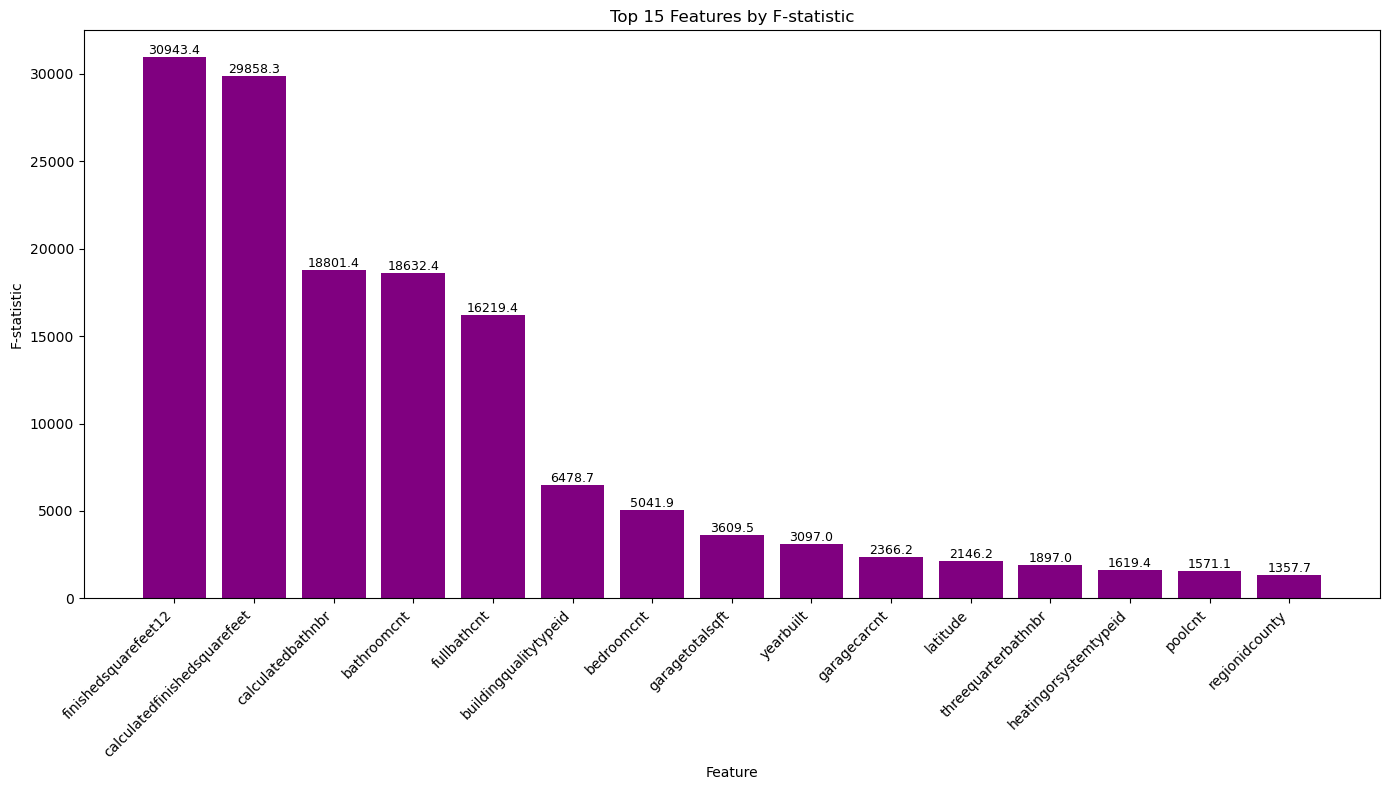

In [27]:
top_features = f_stat_df.head(15)

plt.figure(figsize=(14, 8))
bars = plt.bar(top_features['Feature'], top_features['F_statistic'], color='purple')

plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Features by F-statistic')
plt.ylabel('F-statistic')
plt.xlabel('Feature')

# Add the F-statistic value above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

<div style="border-radius: 10px; border: orange solid; padding: 10px; font-size: 100%;">


The F-statistic results show that some features have a strong relationship with the target variable, `taxvaluedollarcnt`. The most important features are `finishedsquarefeet12`, `calculatedfinishedsquarefeet`, `calculatedbathnbr`, and `bathroomcnt`, which have very high F-statistics. Other features like `buildingqualitytypeid`, `bedroomcnt`, and `garagetotalsqft` also show a clear connection to the target. Even features such as `yearbuilt` and `latitude` have some influence, though their impact is smaller compared to the top features. Overall, these results help identify which features are likely important for predicting property values.

- #### Investigate forward and backward feature selection

In [28]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

We use a basic linear regression model for interpretability.

In [29]:
from sklearn.linear_model import LinearRegression

# Forward Feature Selection
lr_model = LinearRegression()

# Forward selection
sfs_forward = SequentialFeatureSelector(
    lr_model,
    n_features_to_select=10,
    direction='forward',
    scoring='r2',
    cv=5,
    n_jobs=-1
)

sfs_forward.fit(X_scaled, y)

selected_forward = X_numeric.columns[sfs_forward.get_support()]
print("Forward Selected Features:")
print(selected_forward.tolist())

Forward Selected Features:
['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', 'latitude', 'longitude', 'regionidneighborhood', 'roomcnt']


In [30]:
# Backward Selection
sfs_backward = SequentialFeatureSelector(
    lr_model,
    n_features_to_select=10,
    direction='backward',
    scoring='r2',
    cv=5,
    n_jobs=-1
)
sfs_backward.fit(X_scaled, y)
selected_backward = X_numeric.columns[sfs_backward.get_support()]
print("Backward Selected Features:")
print(selected_backward.tolist())

Backward Selected Features:
['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', 'latitude', 'longitude', 'rawcensustractandblock', 'roomcnt']


In [31]:
# Compare
print("Common Features in Both Methods:")
print(set(selected_forward).intersection(set(selected_backward)))

Common Features in Both Methods:
{'latitude', 'longitude', 'buildingqualitytypeid', 'roomcnt', 'calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'garagetotalsqft'}


<div style="border-radius: 10px; border: purple solid; padding: 10px; font-size: 100%;">


The correlation matrix and F-statistic results indicate that <code>finishedsquarefeet12</code>, <code>calculatedfinishedsquarefeet</code>, and <code>calculatedbathnbr</code> have the strongest relationships with the target, <code>taxvaluedollarcnt</code>. This aligns with expectations, as larger homes with more bathrooms generally have higher values. Additional features such as <code>buildingqualitytypeid</code>, <code>bedroomcnt</code>, and <code>garagetotalsqft</code> also show a clear connection to property value.

Forward and backward feature selection using a linear regression model identified nearly the same top features, with **9 out of 10 features overlapping**. Frequently selected features included square footage, bathroom and bedroom counts, garage size, location (latitude and longitude), and <code>buildingqualitytypeid</code>. This strong overlap reinforces the importance of these variables.

In summary, correlation, F-statistics, and feature selection consistently highlight a similar group of features as most important. Each method provides a unique perspective on the relationships, collectively identifying the variables most likely to be useful for modeling property values in subsequent steps.
</div>
</div>


### 2-Dimensional Visualizations for Patterns  

#### 3 pairs of features to visualize

- `calculatedfinishedsquarefeet` and `taxvaluedollarcnt`

- `bathroomcnt` and `taxvaluedollarcnt`

- `latitude` and `longitude` (to explore location clusters and their impact on tax value)

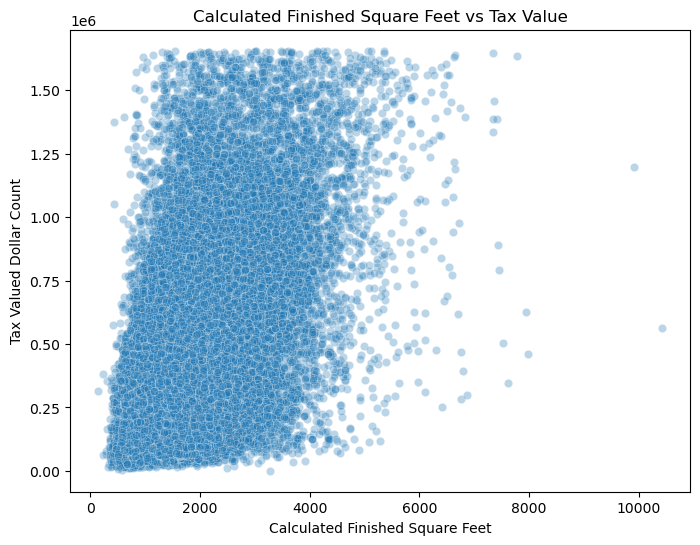

In [32]:
# 1. calculatedfinishedsquarefeet vs taxvaluedollarcnt
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='calculatedfinishedsquarefeet', y='taxvaluedollarcnt', alpha=0.3)
plt.title('Calculated Finished Square Feet vs Tax Value')
plt.xlabel('Calculated Finished Square Feet')
plt.ylabel('Tax Valued Dollar Count')
plt.show()

<div style="border-radius: 10px; border: orange solid; padding: 10px; font-size: 100%;">

This scatter plot shows the relationship between the __size of the property__ (in square feet) and its __tax-assessed value__.

- Non-linear Spread. 
- Most properties fall in the 1,000 to 3,000 square foot range.
- Outliers: A few properties above 6,000 sqft show more scattered tax values - some high, some surprisingly low. These may be special cases or data entry errors.

Finished square footage is a strong predictor of property tax value - which matches our earlier correlation and F-statistic results. However, it's not the only factor, since there's significant variation in tax values for homes of the same size. 

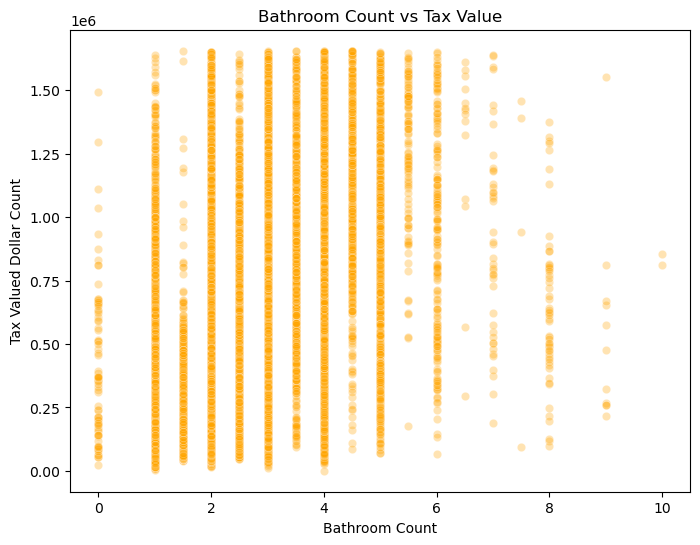

In [33]:
# 2 bathroomcnt vs taxvaluedollarcnt
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='bathroomcnt', y='taxvaluedollarcnt', alpha=0.3, color = 'orange')
plt.title('Bathroom Count vs Tax Value')
plt.xlabel('Bathroom Count')
plt.ylabel('Tax Valued Dollar Count')
plt.show()

<div style="border-radius: 10px; border: orange solid; padding: 10px; font-size: 100%;">


This scatter plot shows how the __number of bathrooms__ in a property relates to its __tax value__.

- No Clear Pattern: The tax values vary widely for every bathroom count. Even homes with the same number of bathrooms can have very different tax values.
- Most Properties Have 1 - 4 Bathrooms. These homes show a wide range of tax values, mostly under $1 million.
- Outliers Exist: Properties with 7 to 10 bathrooms are fewer and have mixed tax values. Some are very high, but others are not, which could indicate luxury homes vs. older large houses.
- More Bathroom is not means a higher value. 

Bathroom count alone is not a strong predictor of property value. It may help when used with other features like square footage, location, or home condition, but on its own, it's too inconsistent.



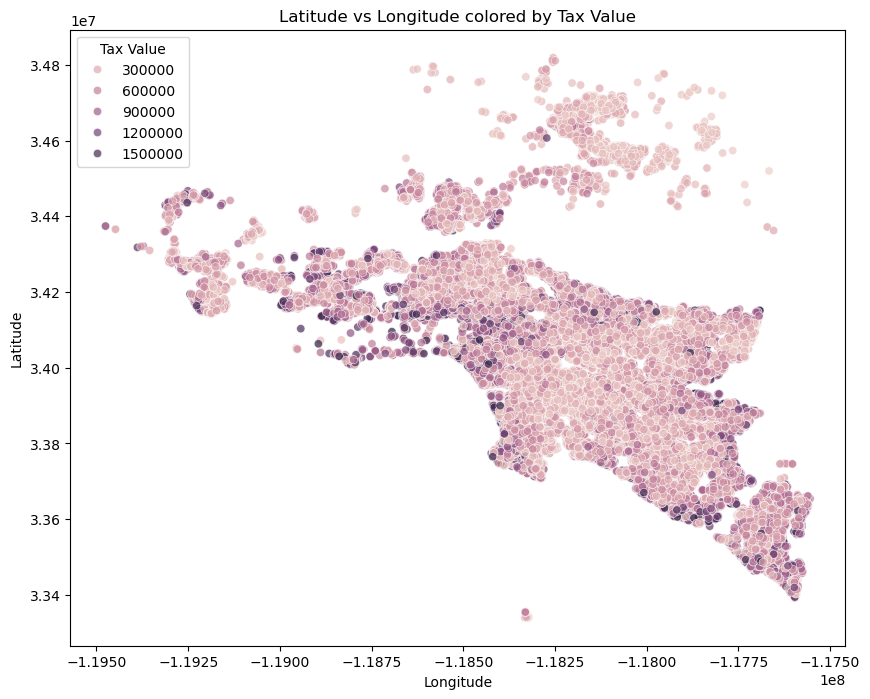

In [34]:
# 3. latitude vs longitude colored by taxvaluedollarcnt
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='taxvaluedollarcnt', alpha=0.7)
plt.title('Latitude vs Longitude colored by Tax Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Tax Value')
plt.show()

<div style="border-radius: 10px; border: orange solid; padding: 10px; font-size: 100%;">

This plot shows the __geographic distribution__ of properties, with color representing the tax-assessed value of each one.

- Location matters: Some areas clearly have higher property values than others. We can see darker-colored points (higher values) grouped together in specific zones.

Geography strongly impacts property value. This pattern could be useful for modeling - latitude and longitude may help predict property value.



## **Appendix 1: Features of the Zillow Dataset**  

| Column_Name                  | Description                                                                                       |
|-------------------------------|---------------------------------------------------------------------------------------------------|
| parcelid                      | Unique identifier for the property parcel.                                                       |
| airconditioningtypeid         | Identifier for the type of air conditioning installed.                                           |
| architecturalstyletypeid      | Identifier for the architectural style of the property.                                          |
| basementsqft                  | Square footage of the basement.                                                                 |
| bathroomcnt                   | Number of bathrooms.                                                                             |
| bedroomcnt                    | Number of bedrooms.                                                                              |
| buildingclasstypeid           | Identifier for the building framing type (e.g., wood frame, steel frame).                        |
| buildingqualitytypeid         | Numeric value indicating the quality of the building (higher values often indicate better quality). |
| calculatedbathnbr             | Calculated number of bathrooms, including fractional bathrooms.                                  |
| decktypeid                     | Identifier for the type of deck.                                                                |
| finishedfloor1squarefeet      | Square footage of the finished area on the first floor.                                         |
| calculatedfinishedsquarefeet  | Total finished living area square footage.                                                      |
| finishedsquarefeet12          | Finished living area square footage.                                                           |
| finishedsquarefeet13          | Perimeter living area square footage.                                                          |
| finishedsquarefeet15          | Total area.                                                                                     |
| finishedsquarefeet50          | Square footage of the finished area on the upper floors.                                        |
| finishedsquarefeet6           | Base unfinished and finished area square footage.                                              |
| fips                          | Federal Information Processing Standards code, uniquely identifying counties and county equivalents. |
| fireplacecnt                  | Number of fireplaces.                                                                           |
| fullbathcnt                   | Number of full bathrooms.                                                                       |
| garagecarcnt                  | Number of cars that can fit in the garage.                                                     |
| garagetotalsqft               | Total square footage of the garage.                                                            |
| hashottuborspa                | Indicates if the property has a hot tub or spa.                                                |
| heatingorsystemtypeid         | Identifier for the type of heating system.                                                     |
| latitude                      | Latitude coordinate of the property.                                                          |
| longitude                     | Longitude coordinate of the property.                                                         |
| lotsizesquarefeet             | Lot size in square feet.                                                                       |
| poolcnt                       | Number of pools on the property.                                                              |
| poolsizesum                   | Total square footage of all pools.                                                            |
| pooltypeid10                  | Identifier for spa or hot tub.                                                                |
| pooltypeid2                   | Identifier for pool with spa or hot tub.                                                     |
| pooltypeid7                   | Identifier for pool without hot tub or spa.                                                  |
| propertycountylandusecode     | County land use code for the property.                                                       |
| propertylandusetypeid         | Identifier for the property land use type.                                                   |
| propertyzoningdesc            | Description of the property's zoning.                                                        |
| rawcensustractandblock        | Unprocessed census tract and block identifier.                                               |
| regionidcity                  | Identifier for the city.                                                                      |
| regionidcounty                | Identifier for the county.                                                                    |
| regionidneighborhood          | Identifier for the neighborhood.                                                              |
| regionidzip                   | Identifier for the ZIP code.                                                                 |
| roomcnt                       | Total number of rooms.                                                                        |
| storytypeid                   | Identifier for the type of stories in the building (e.g., basement, attic).                  |
| threequarterbathnbr           | Number of 3/4 bathrooms (typically includes a shower but no tub).                             |
| typeconstructiontypeid        | Identifier for the type of construction (e.g., frame, masonry).                               |
| unitcnt                       | Number of units in the building (e.g., for multi-family properties).                          |
| yardbuildingsqft17            | Square footage of the 17th yard building (e.g., shed).                                        |
| yardbuildingsqft26            | Square footage of the 26th yard building.                                                    |
| yearbuilt                     | Year the property was built.                                                                 |
| numberofstories               | Number of stories in the b

